In [1]:
from library.objective_function import *
from library.optimiser import *
from library.post_analysis import *
from library.experiments import *
%matplotlib inline
SEED = 12237

In [2]:
def do_multiple_exps(obj, opt, zoneParas):
    np.random.seed(SEED)
    
    # init multiple experiments
    mexps = multiple_experiment()

    # init one experiment
    exp = single_experiment()
    
    # One experiment: setup objective function and optimiser
    exp.set_objective(obj)
    exp.set_optimizer(opt)

    # Multiple experiment: setup one expreiment
    mexps.set_single_exp(exp)
    # Multiple experiment: setup sample zone    
    mexps.set_sample_zone(zoneParas)
    
    data = mexps.do()
    
    return data

# Original Ackley

In [ ]:
import numpy as np
from abc import ABC, abstractmethod

class optimizer(ABC):
    @abstractmethod
    def set_parameters(self, para):
        '''
        input: parameters, in dictionary
        '''
        pass
    @abstractmethod
    def optimise(self, objective_cls):
        '''
        input: objective function class
        output: empirical found optimal, optimum, and statistics of procedure information
        '''
        pass
    
class adjust_optimizer(optimizer):
    def adjust(self, x0, obj):
        self.x0 = x0
        self.variable = x0.ravel()
        arg, val, stats = self.optimise(obj)
        return arg, val, stats['evals']
    
class cma_es(adjust_optimizer):
    def __init__(self, dim=2):
        self.dim = dim
        paras = {'x0': np.zeros((dim,)),
                 'std': np.ones((dim,)) * 3, 
                 'tol': 1e-5, 
                 'adjust_func': do_nothing(), 
                 'record': False, 
                 'verbose': False}
        self.set_parameters(paras)
    def set_parameters(self, paras):
        self.paras = paras
        self.x0 = paras['x0'] 
        self.std = paras['std']
        self.tol = paras['tol']
        self.adjust_func = paras['adjust_func']
        self.max_iter = 400 if 'max_iter' not in paras.keys() else paras['max_iter']
        # set none to use default value 
        self.cluster_size = None if 'cluster_size' not in paras.keys() else paras['cluster_size']
        self.survival_size = None if 'survival_size' not in paras.keys() else paras['survival_size']
        self.record = True if 'record' not in paras.keys() else paras['record']
        self.verbose = True if 'verbose' not in paras.keys() else paras['verbose']
    def optimise(self, obj):
        '''
        @param obj: objective function class instance
        return arg: found minimum arguments
               val: found minimum value
               stats: collection of recorded statistics for post-analysis
        '''                  
        def update_mean(x):
            return (weights @ x).reshape(dim, 1)
        def update_ps(ps, sigma, C, mean, mean_old):
            return (1 - cs) * ps + np.sqrt(cs * (2 - cs) * mueff) * invsqrtC @ (mean - mean_old) / sigma 
        def update_pc(pc, sigma, ps, mean, mean_old):
            hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
            return (1 - cc) * pc + hsig * np.sqrt(cc * (2 - cc) * mueff) * (mean - mean_old) / sigma
        def update_C(C, pc, x, mean_old, sigma):
            hsig = np.abs(ps) / np.sqrt(1 - (1 - cs)**(2 * iter_/lambda_)) / chiN < 1.4 + 2/(dim + 1)
            artmp = (1 / sigma) * (x - mean_old.reshape(1, dim))
            return (1 - c1 - cmu) * C + c1 * (pc * pc.T + (1 - hsig) * cc * (2 - cc) * C) + cmu * artmp.T @ np.diag(weights) @ artmp
        def update_sigma(sigma, ps):
            return sigma * np.exp((cs / damps) * (np.linalg.norm(ps)/ chiN - 1))
        def is_not_moving(arg, val, pre_arg, pre_val, tol):
            dis_arg = np.linalg.norm(arg - pre_arg)
            dis_val = np.linalg.norm(val - pre_val)
            return (dis_arg < tol) or (dis_val < tol) 

        if self.verbose:
            print("\n\n*******starting optimisation from intitial mean: ", self.x0.ravel())
        # User defined input parameters 
        dim = self.dim
        sigma = 0.3
        D = self.std / sigma
        mean = self.x0.reshape(dim, 1)

        # the size of solutions group
        lambda_ = 4 + int(3 * np.log(dim)) if self.cluster_size == None else self.cluster_size  
        # only best "mu" solutions are used to generate iterations
        mu = int(lambda_ / 2) if self.survival_size == None else self.survival_size
        # used to combine best "mu" solutions                                               
        weights = np.log(mu + 1/2) - np.log(np.arange(mu) + 1) 
        weights = weights / np.sum(weights)     
        mueff = np.sum(weights)**2 / np.sum(weights**2) 

        # Strategy parameter setting: Adaptation
        # time constant for cumulation for C
        cc = (4 + mueff / dim) / (dim + 4 + 2 * mueff / dim)  
        # t-const for cumulation for sigma control
        cs = (mueff + 2) / (dim + mueff + 5)  
        # learning rate for rank-one update of C
        c1 = 2 / ((dim + 1.3)**2 + mueff)    
        # and for rank-mu update
        cmu = min(1 - c1, 2 * (mueff - 2 + 1 / mueff) / ((dim + 2)**2 + mueff))  
        # damping for sigma, usually close to 1  
        damps = 1 + 2 * max(0, np.sqrt((mueff - 1)/( dim + 1)) - 1) + cs                                                                 

        # Initialize dynamic (internal) strategy parameters and constants
        # evolution paths for C and sigma
        pc = np.zeros((dim, 1))     
        ps = np.zeros((dim, 1)) 
        # B defines the coordinate system
        B = np.eye(dim)       
        # covariance matrix C
        C = B * np.diag(D**2) * B.T 
        # C^-1/2 
        invsqrtC = B * np.diag(D**-1) * B.T   
        # expectation of ||N(0,I)|| == norm(randn(N,1)) 
        chiN = dim**0.5 * (1 - 1/(4 * dim) + 1 / (21 * dim**2))  

        # --------------------  Initialization --------------------------------  
        x, x_old, f = np.zeros((lambda_, dim)), np.zeros((lambda_, dim)), np.zeros((lambda_,))
        stats = {}
        stats['val'], stats['arg'] = [], []
        stats['x_adjust'] = []
        iter_eval, stats['evals_per_iter'] = np.zeros((lambda_, )), []
        stats['mean'], stats['std'] = [], []
        stats['status'] = None
        iter_, eval_ = 0, 0
        # initial data in record
        for i in range(lambda_):
            x[i] = (mean + np.random.randn(dim, 1)).ravel()
            f[i] = obj.func(x[i])
        idx = np.argsort(f)
        x_ascending = x[idx]
        if self.record:
            stats['arg'].append(x_ascending)
            stats['val'].append(f[idx])
            stats['mean'].append(mean)
            stats['std'].append(sigma * B @ np.diag(D))
            stats['evals_per_iter'].append(np.ones((lambda_,)))
            stats['x_adjust'].append(np.vstack((x.T.copy(), x.T.copy())))
        arg = x_ascending
        val = f[idx]
        pre_arg = x_ascending
        pre_val = f[idx]
        best_val = 1e4
        best_arg = None
        
        # optimise by iterations
        try:
            while iter_ < self.max_iter:
                iter_ += 1
                # generate candidate solutions with some stochastic elements
                for i in range(lambda_):
                    x[i] = (mean + sigma * B @ np.diag(D) @ np.random.randn(dim, 1)).ravel() 
                    x_old[i] = x[i]
                    x[i], f[i], eval_cnt = self.adjust_func.adjust(x[i], obj)
                    eval_ += eval_cnt
                    iter_eval[i] = eval_cnt
                # sort the value and positions of solutions 
                idx = np.argsort(f)
                x_ascending = x[idx]

                # update the parameter for next iteration
                mean_old = mean
                mean = update_mean(x_ascending[:mu])
                ps =   update_ps(ps, sigma, C, mean, mean_old)
                pc =   update_pc(pc, sigma, ps, mean, mean_old)
                sigma = update_sigma(sigma, ps)
                C =    update_C(C, pc, x_ascending[:mu], mean_old, sigma)
                C = np.triu(C) + np.triu(C, 1).T
                D, B = np.linalg.eig(C)
                D = np.sqrt(D)
                invsqrtC = B @ np.diag(D**-1) @ B

                # record data during process for post analysis
                if self.record:
                    stats['arg'].append(x_ascending)
                    stats['val'].append(f[idx])
                    stats['mean'].append(mean)
                    stats['std'].append(sigma * B @ np.diag(D))
                    stats['evals_per_iter'].append(iter_eval.copy())
                    stats['x_adjust'].append(np.vstack((x_old.T.copy(), x.T.copy())))
                # stopping condition    
                arg = x_ascending
                val = f[idx]
                if best_val > val[0]:
                    best_val = val[0]
                    best_arg = arg[0]              
                # check the stop condition
                if np.max(D) > (np.min(D) * 1e6):
                    stats['status'] = 'diverge'
                    print('diverge, concentrate in low dimension manifold')
                    break
                if is_not_moving(arg, val, pre_arg, pre_val, self.tol) :
                    break
                pre_arg = arg
                pre_val = val
        except np.linalg.LinAlgError as err:
            stats['status'] = 'diverge'
            print('diverge, raise LinAlgError!')
        finally:
            if self.verbose:
                print('eigenvalue of variance = {}'.format(D))
                print('total iterations = {}, total evaluatios = {}'.format(iter_, eval_))
                print('found minimum position = {}, found minimum = {}'.format(best_arg, best_val))

        # carry statistics info before quit
        if self.record:
            stats['arg'] = np.array(stats['arg'])
            stats['val'] = np.array(stats['val'])
            stats['mean'] = np.array(stats['mean'])
            stats['std'] = np.array(stats['std'])
            stats['evals_per_iter'] = np.array(stats['evals_per_iter'])
            stats['x_adjust'] = np.array(stats['x_adjust'])
        stats['evals'] = eval_
        return best_arg, best_val, stats

In [94]:
class single_experiment:
    def __init__(self, tol=0.1):
        self.tol = tol
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < self.tol \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < self.tol:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
        if self.optimizer.verbose:
            print("Result: ", statistics['status'])
            print("found minimum: {}, minimum position: {}, evals: {}".format(optimum, optimal.ravel(), statistics['evals']))
        if self.optimizer.record == False:
            return statistics['status'], optimum, statistics['evals']
        else:
            statistics['optimal'] = self.objective_func.get_optimal()
            statistics['optimum'] = self.objective_func.get_optimum()
            return statistics

In [144]:
class post_analysis_single():
    def __init__(self, stats):
        self.stats = stats
        self.optimal = stats['optimal']
        self.optimum = stats['optimum']
    def print_mean_variance(self):
        # print mean and variance of each iteration
        for i, a in enumerate(self.stats['std']):
            print('iter=',i, 'mean=', self.stats['mean'][i].T , '\nvar=\n', a@a.T, '\n')

    def print_evaluations_per_iteration(self):
        for i, iter_ in enumerate(self.stats['evals_per_iter']):
            print('iter=', i, '\n', iter_.squeeze(),'\n') 

    def print_points_before_and_after_adjust(self):
        for i, iter_ in enumerate(self. stats['x_adjust']):
            print('iter=', i, '\nbefore\n', iter_[:2], '\nafter\n', iter_[2:], '\n') 

    def __cal_distance(self):
        self.distance_arg = np.linalg.norm(stats['arg'] - stats['optimal'].reshape(1,1,2), axis=2).mean(axis=1)
        self.distance_val = self.stats['val'].mean(axis=1)
            
    def plot_distance(self):
        self.__cal_distance()
        fig = plt.figure(figsize=(8, 4))
        ax1 = fig.add_subplot(1, 1, 1)
        self.__plot_distance_common(ax1, self.stats['val'].shape[0]-1)
    
    def plot_moving_cluster(self):
        fig = plt.figure(figsize=(9, 9))
        row = col = 3
        unit = int(self.stats['val'].shape[0]/(row * col)/2)
        for i in range(row):
            for j in range(col):
                ax=fig.add_subplot(row, col, 1 + row * i + j)
                # draw x-axis and y-axis
                ax.axvline(c='grey', lw=1)
                ax.axhline(c='grey', lw=1)
                # draw the position of optimal 
                ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
                ax.scatter(x=self.stats['arg'][unit * (row * i + j),:,0], y=self.stats['arg'][unit * (row * i + j),:,1], 
                           c=self.stats['val'][unit * (row * i + j)], vmin = 0, vmax = 10)
                ax.set_title("%d / %d"%(unit * (row * i + j), self.stats['arg'].shape[0]))
                plt.xlim([-4, 4])
                plt.ylim([-4, 4])

    def __plot_distance_common(self, ax1, i):
        ax1.plot(np.arange(i), self.distance_arg[1:i+1], color='green', label='Frobenius norm \nof parameters')
        ax1.set_xlim(0, self.stats['val'].shape[0])
        ax1.set_ylim(np.min(self.distance_arg)*0.9, np.max(self.distance_arg)*1.1)
        ax1.set_xlabel('iteration', fontsize=15)
        ax1.set_ylabel('distance in domain', color='green', fontsize=15)
        ax1.tick_params(axis='y', labelcolor='green')
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()  
        ax2.plot(np.arange(i), self.distance_val[1:i+1], color='red', label='L2 norm \nof func value')
        ax2.set_ylim(np.min(self.distance_val)*0.9, np.max(self.distance_val)*1.1)
        ax2.set_ylabel('distance in codomain', color='red', fontsize=15)
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.legend(loc='upper right') 
        
    def __draw_ellipse(self, ax, mean, std):
        eigVal_sqrt = np.linalg.norm(std, ord=2, axis=(0))
        eigVec = std / eigVal_sqrt
        width, height = 2 * 3 * eigVal_sqrt
        angle = np.arctan2(eigVec[0,1], eigVec[0,0]) * 180 / np.pi
        e1 = patches.Ellipse(mean, width, height,
                             angle=-angle, linewidth=2, fill=False, zorder=2)
        ax.add_patch(e1)
        ax.scatter(mean[0], mean[1], c='black', s=15)

    def __setup_scatter(self, ax, i):
        '''
        set up the plot of CMA-ES candidates at i-th iteration
        '''
        # draw x-axis and y-axis
        ax.axvline(c='grey', lw=1)
        ax.axhline(c='grey', lw=1)
        # draw the position of optimal 
        ax.scatter(self.optimal[0], self.optimal[1], c='red', s=15)
        # draw the trail of local minimum
        if 'trail' in self.stats.keys():
            ax.scatter(self.stats['trail'][0], self.stats['trail'][1], c='red', s=11)
        # draw candidates on scatter plot
        ax.set_xlim(np.min(self.stats['arg'][:,:,0]), np.max(self.stats['arg'][:,:,0]))
        ax.set_ylim(np.min(self.stats['arg'][:,:,1]), np.max(self.stats['arg'][:,:,1]))
        p = sns.scatterplot(x=self.stats['arg'][i,:,0], y=self.stats['arg'][i,:,1], color="r", hue=i, hue_norm=(0, self.stats['val'].shape[0]), legend=False)
        # draw ellipse representing 3 sigma areas of normal distribution
        self.__draw_ellipse(ax, self.stats['mean'][i], self.stats['std'][i])

    def animate_moving_cluster(self):
        def animate(i):
            plt.clf()
            ax = fig.add_subplot(1, 1, 1)    
            ax.set_title('iter=%d' % (i+1))
            self.__setup_scatter(ax, i+1)
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['arg'].shape[0]-1, repeat=False, interval=500)
        return ani

    def animate_scatterplot_distance(self):
        def animate(i):
            plt.clf()
            # draw scatter and ellipse
            ax0 = fig.add_subplot(2, 1, 1)
            ax0.set_title('iter=%d, func_dist=%.3f,  arg_dist=%.3f, mean=(%.3f, %.3f)' % (i+1, self.distance_val[i+1], self.distance_arg[i+1], \
                                        self.stats['mean'][i+1,0], self.stats['mean'][i+1,1]))
            self.__setup_scatter(ax0, i+1)
            
            # plot distance
            ax1 = fig.add_subplot(2, 1, 2)
            self.__plot_distance_common(ax1, i+1)
        self.__cal_distance()
        fig = plt.figure(figsize=(8,4))
        ani = animation.FuncAnimation(fig, animate, frames=self.stats['val'].shape[0]-1, repeat=False, interval=500)
        return ani

In [123]:
# 1 optimiser
opt = cma_es()
optParas ={'x0': np.array([102.33, 56.56]),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': round_off(), 
           'record': True, 
           'verbose': True}
opt.set_parameters(optParas)

# 2 objective function
obj = ackley()

# init one experiment
exp = single_experiment()

# One experiment: setup objective function and optimiser
exp.set_objective(obj)
exp.set_optimizer(opt)
stats = exp.do()



*******starting optimisation from intitial mean:  [102.33  56.56]
eigenvalue of variance = [2.14297652 3.47825284]
total iterations = 46, total evaluatios = 276
found minimum position = [101.  67.], found minimum = 20.005770995138814
Result:  local minimum
found minimum: 20.005770995138814, minimum position: [101.  67.], evals: 276


In [145]:
ana = post_analysis_single(stats)

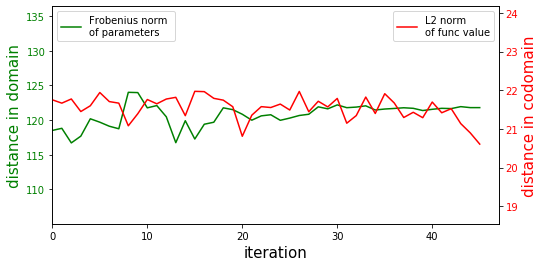

In [146]:
ana.plot_distance()

## adam

In [72]:
# 1 optimiser
opt = adam()
optParas = {
         'x0': None,
         'alpha': 1e-1,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 2000,
         'tol': 1e-3,              
         'verbose': False,
         'record': False }
opt.set_parameters(optParas)

# 2 objective function
obj = ackley()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([0, 0]),
             'edge': np.array([500, 500]),
             'step': 20,
             'size': 10,
             'sym': True}

data = do_multiple_exps(obj, opt, zoneParas)

cost: 16.412734215354554, prob: 0.0
complete: 1 / 325 
cost: 19.91228679566393, prob: 0.0
complete: 3 / 325 
cost: 20.02035210873399, prob: 0.0
complete: 6 / 325 
cost: 20.00477133078358, prob: 0.0
complete: 10 / 325 
cost: 20.00375963276011, prob: 0.0
complete: 15 / 325 
cost: 20.000881387371873, prob: 0.0
complete: 21 / 325 
cost: 20.0021782823075, prob: 0.0
complete: 28 / 325 
cost: 20.001057079802607, prob: 0.0
complete: 36 / 325 
cost: 20.011484237182046, prob: 0.0
complete: 45 / 325 
cost: 20.00459190718819, prob: 0.0
complete: 55 / 325 
cost: 20.019606835958218, prob: 0.0
complete: 66 / 325 
cost: 20.001309741137483, prob: 0.0
complete: 78 / 325 
cost: 20.003702731763653, prob: 0.0
complete: 91 / 325 
cost: 20.004950399654795, prob: 0.0
complete: 105 / 325 
cost: 20.001555639472006, prob: 0.0
complete: 120 / 325 
cost: 20.003421592273508, prob: 0.0
complete: 136 / 325 
cost: 20.014711655561605, prob: 0.0
complete: 153 / 325 
cost: 20.001482868988337, prob: 0.0
complete: 171 / 32

In [73]:
ana_ad_ak = post_analysis_zone(data)

Text(0.5, 1, 'cost of ackley, optimised by adam')

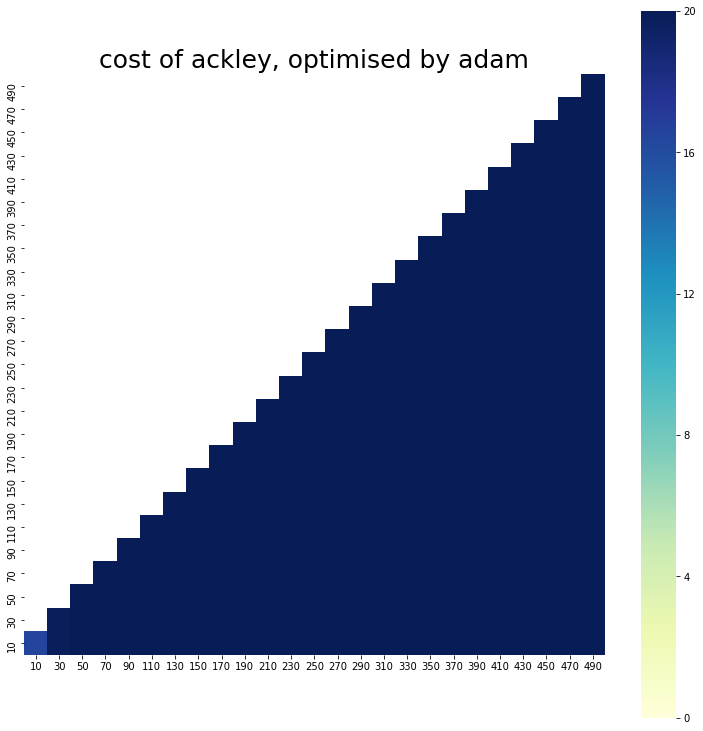

In [78]:
ax = ana_ad_ak.plot_hotmap_cost(20)
ax.set_title("cost of ackley, optimised by adam", fontsize=25)

## cma

In [79]:
# 1 optimiser
opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': do_nothing(), 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = ackley()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([0, 0]),
             'edge': np.array([500, 500]),
             'step': 20,
             'size': 10,
             'sym': True}
data = do_multiple_exps(obj, opt, zoneParas)

cost: 0.0002703256652478281, prob: 1.0
complete: 1 / 325 
cost: 15.248339951811108, prob: 0.2
complete: 3 / 325 
cost: 16.96300460406329, prob: 0.1
complete: 6 / 325 
cost: 17.144063363929025, prob: 0.1
complete: 10 / 325 
cost: 17.998072350973807, prob: 0.1
complete: 15 / 325 
cost: 17.57633691560401, prob: 0.1
complete: 21 / 325 


/Users/huajian/Non-convex/library/optimiser.py:168: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/Non-convex/library/optimiser.py:60: RuntimeWarning:

invalid value encountered in less

/Users/huajian/Non-convex/library/optimiser.py:63: RuntimeWarning:

invalid value encountered in less



diverge, raise LinAlgError!
cost: 19.95508599713287, prob: 0.0
complete: 28 / 325 
cost: 18.76681304415323, prob: 0.0
complete: 36 / 325 
cost: 20.00190811509771, prob: 0.0
complete: 45 / 325 
diverge, raise LinAlgError!
cost: 20.002494895931918, prob: 0.0
complete: 55 / 325 
diverge, raise LinAlgError!
cost: 18.001225542324928, prob: 0.1
complete: 66 / 325 
cost: 20.000876879765784, prob: 0.0
complete: 78 / 325 
cost: 19.91797394644447, prob: 0.0
complete: 91 / 325 
diverge, raise LinAlgError!
diverge, raise LinAlgError!
cost: 20.002168934125145, prob: 0.0
complete: 105 / 325 
cost: 19.873966162667376, prob: 0.0
complete: 120 / 325 
diverge, raise LinAlgError!
cost: 20.001039463399884, prob: 0.0
complete: 136 / 325 
cost: 20.000987730186154, prob: 0.0
complete: 153 / 325 
diverge, raise LinAlgError!
diverge, raise LinAlgError!
cost: 20.005269258350978, prob: 0.0
complete: 171 / 325 
diverge, raise LinAlgError!
cost: 20.00098527368339, prob: 0.0
complete: 190 / 325 
cost: 20.0016513126

In [80]:
ana_cma_ak = post_analysis_zone(data)

Text(0.5, 1, 'cost of ackley, optimised by adam')

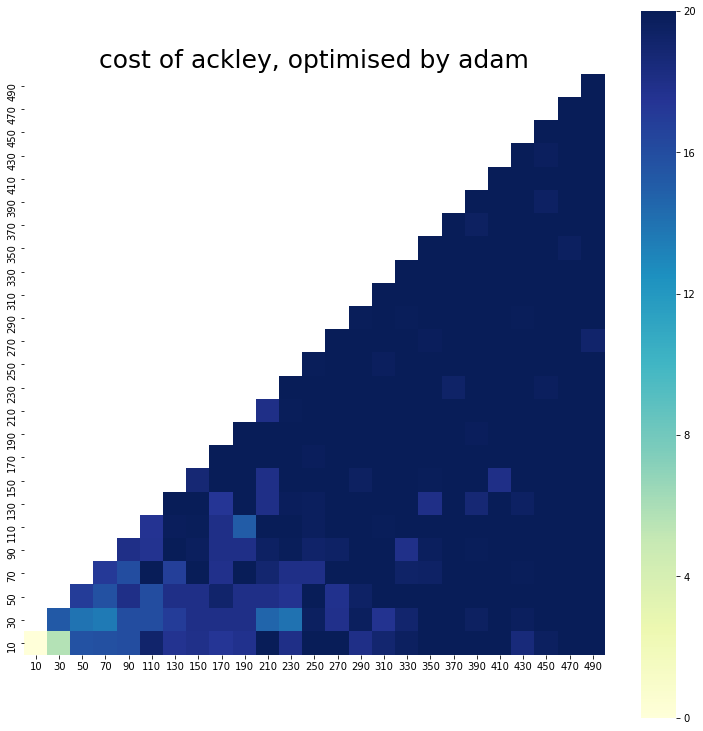

In [81]:
ax = ana_cma_ak.plot_hotmap_cost(20)
ax.set_title("cost of ackley, optimised by adam", fontsize=25)

## cma line search

In [ ]:
# 1 optimiser
inner_opt = line_search()
innerOptParas = {
    'x0': None,
    'alpha': 1,
    'beta': 0.01, 
    'max_iter': 100,
    'tol': 1e-2,              
    'verbose': False,
    'record': False
}
inner_opt.set_parameters(innerOptParas)

opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': round_off(), 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = ackley()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([0, 0]),
             'edge': np.array([500, 500]),
             'step': 20,
             'size': 10,
             'sym': True}
data = do_multiple_exps(obj, opt, zoneParas)

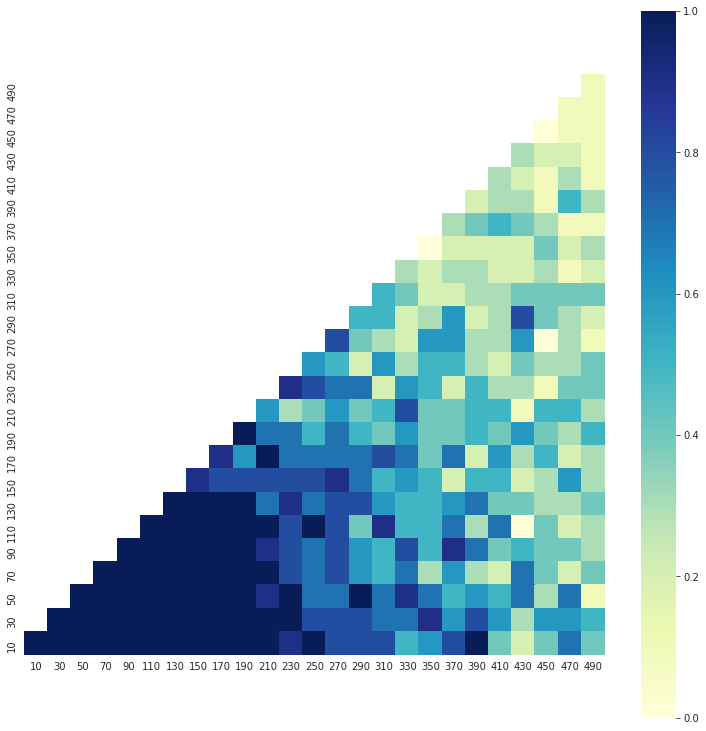

In [27]:
ana.plot_hotmap_prob()

### adam + original Ackley

In [5]:
ad = adam()
optmizerParas = {
         'x0': None,
         'alpha': 1.075330,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 200,
         'tol': 1e-3,              
         'verbose': False,
         'record': False }
ad.set_parameters(optmizerParas)
%time ana = do_multiple_exps_on_ackley(ad, SEED)

complete: 1 / 325 
complete: 3 / 325 
complete: 6 / 325 
complete: 10 / 325 
complete: 15 / 325 
complete: 21 / 325 
complete: 28 / 325 
complete: 36 / 325 
complete: 45 / 325 
complete: 55 / 325 
complete: 66 / 325 
complete: 78 / 325 
complete: 91 / 325 
complete: 105 / 325 
complete: 120 / 325 
complete: 136 / 325 
complete: 153 / 325 
complete: 171 / 325 
complete: 190 / 325 
complete: 210 / 325 
complete: 231 / 325 
complete: 253 / 325 
complete: 276 / 325 
complete: 300 / 325 
complete: 325 / 325 

avg probility of converge:  0.0
avg func value:  20.08322999159664
avg evals per exp:  189.112


CPU times: user 35.2 s, sys: 1.11 s, total: 36.4 s
Wall time: 36.2 s


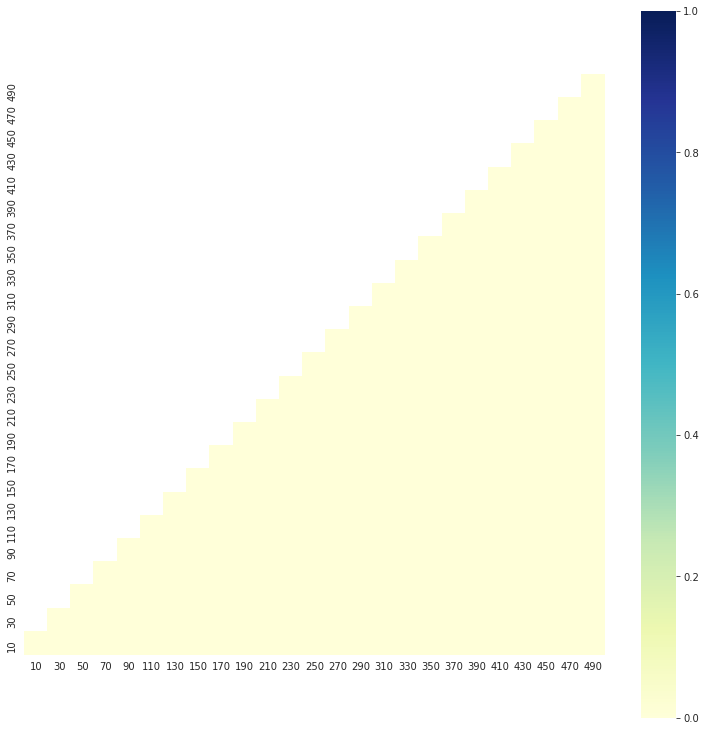

In [9]:
ana.plot_hotmap_prob()

# bukin + original CMA

In [7]:
def do_multiple_exps_on_bukin(optimizer, seed):
    np.random.seed(seed)

    # init multiple experiments
    mexps = multiple_experiment()

    # init and setup one experiment
    exp = single_experiment()
    # One experiment: setup objective function
    bk = bukin()
    exp.set_objective(bk)
    exp.set_optimizer(optimizer)

    # Multiple experiment: setup one expreiment
    mexps.set_single_exp(exp)
    # Multiple experiments: setup sample zone of multiple experiments
    zoneParas = {'origin': np.array([-15,-5]),
             'edge': np.array([30, 10]),
             'step': 1,
             'size': 10,
             'sym': False}
    mexps.set_sample_zone(zoneParas)

    data = mexps.do()
    
    print("avg probility of converge: ", data['res'].mean())
    print("avg func value: ", data['cost'].mean())
    print("avg evals per exp: ", data['evals'].mean())
    print("\n")
    return mexps.analyser

In [8]:
def setup_compsite_cma_bukin(inner_opt):
    # One experiment: setup optimizer
    cma = cma_es()
    optmizerParas = {
             'x0': np.zeros((2,)),
             'std': np.ones((2,)) * 0.3, 
             'tol': 1e-2, 
             'max_iter': 5,
             'adjust_func': inner_opt, 
             'record': False, 
             'verbose': False}
    cma.set_parameters(optmizerParas)
    return cma

In [79]:
cma = setup_compsite_cma_bukin(do_nothing())
%time ana_cma = do_multiple_exps_on_bukin(cma, SEED)

complete: 10 / 300 
complete: 20 / 300 
complete: 30 / 300 
complete: 40 / 300 
complete: 50 / 300 
complete: 60 / 300 
complete: 70 / 300 
complete: 80 / 300 
complete: 90 / 300 
complete: 100 / 300 
complete: 110 / 300 
complete: 120 / 300 
complete: 130 / 300 
complete: 140 / 300 
complete: 150 / 300 
complete: 160 / 300 
complete: 170 / 300 
complete: 180 / 300 
complete: 190 / 300 
complete: 200 / 300 
complete: 210 / 300 
complete: 220 / 300 
complete: 230 / 300 
complete: 240 / 300 
complete: 250 / 300 
complete: 260 / 300 
complete: 270 / 300 
complete: 280 / 300 
complete: 290 / 300 
complete: 300 / 300 
avg probility of converge:  0.0006666666666666668
avg func value:  0.9985292005261615
avg evals per exp:  1589.258


CPU times: user 4min 52s, sys: 1.91 s, total: 4min 54s
Wall time: 5min 1s


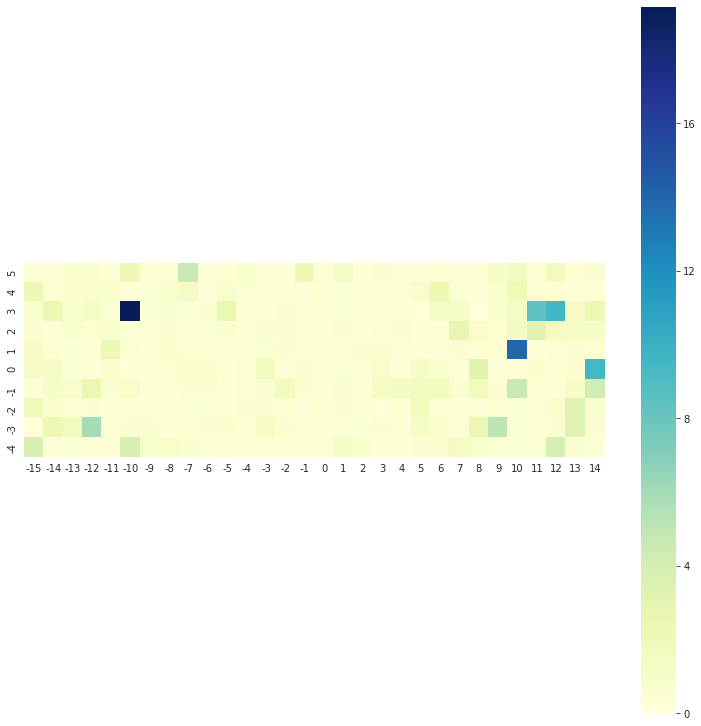

In [80]:
ana_cma.plot_hotmap_cost()

## cma line search + bukin

In [8]:
optmizerParas = {'x0': np.zeros((2,)),
         'alpha': 1,
         'beta': 0.1, 
         'max_iter': 100,
         'tol': 1e-2,              
         'verbose': False,
         'record': False}
ls = line_search()
ls.set_parameters(optmizerParas)

cma_ln = setup_compsite_cma_bukin(ls)
%time ana_cma = do_multiple_exps_on_bukin(cma_ln, SEED)

cost: 0.004977492211964464, prob: 1.0
complete: 10 / 300 
cost: 0.005870763584625622, prob: 1.0
complete: 20 / 300 
cost: 0.007353374994459309, prob: 1.0
complete: 30 / 300 
cost: 0.00316592920018609, prob: 1.0
complete: 40 / 300 
cost: 0.001509673487432014, prob: 1.0
complete: 50 / 300 
cost: 0.004519491826781642, prob: 1.0
complete: 60 / 300 
cost: 0.009232318608051165, prob: 1.0
complete: 70 / 300 
cost: 0.01144470823059614, prob: 1.0
complete: 80 / 300 
cost: 0.01833173241797371, prob: 1.0
complete: 90 / 300 
cost: 0.02242406857029488, prob: 1.0
complete: 100 / 300 
cost: 0.03212065191450036, prob: 1.0
complete: 110 / 300 
cost: 0.04850066682065908, prob: 1.0
complete: 120 / 300 
cost: 0.03652817406590911, prob: 1.0
complete: 130 / 300 
cost: 0.036868144967873336, prob: 1.0
complete: 140 / 300 
cost: 0.0448237266636279, prob: 1.0
complete: 150 / 300 
cost: 0.03905086080841108, prob: 0.8
complete: 160 / 300 
cost: 0.04659561293319282, prob: 0.9
complete: 170 / 300 
cost: 0.046148785

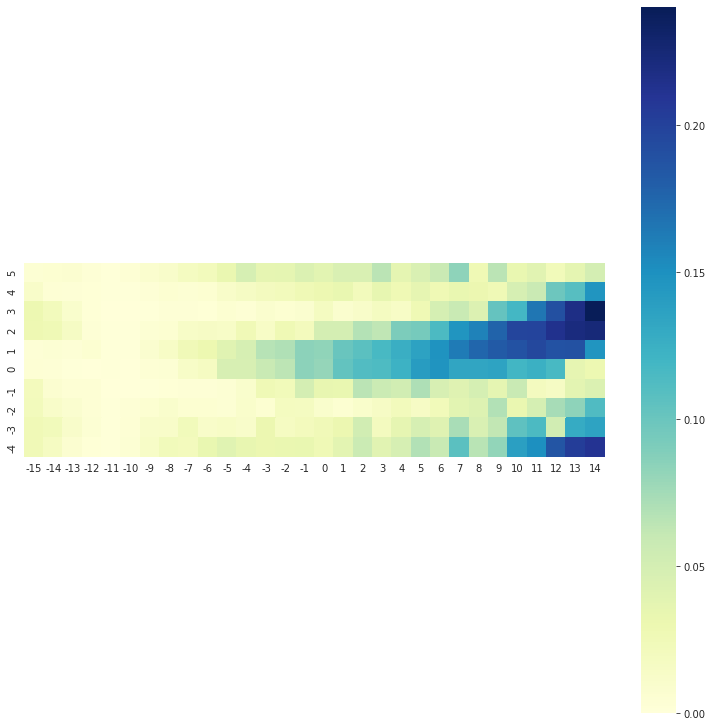

In [9]:
ana_cma.plot_hotmap_cost()

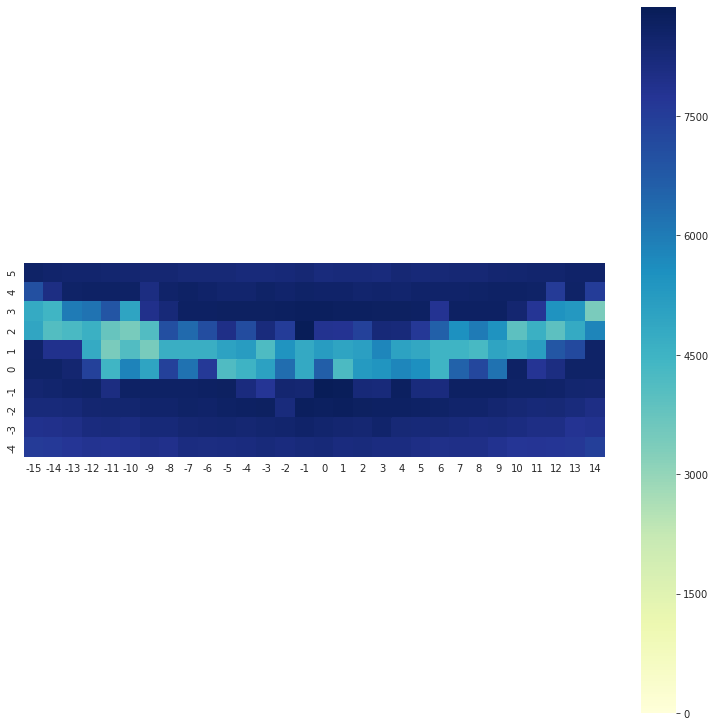

In [10]:
ana_cma.plot_hotmap_evals()

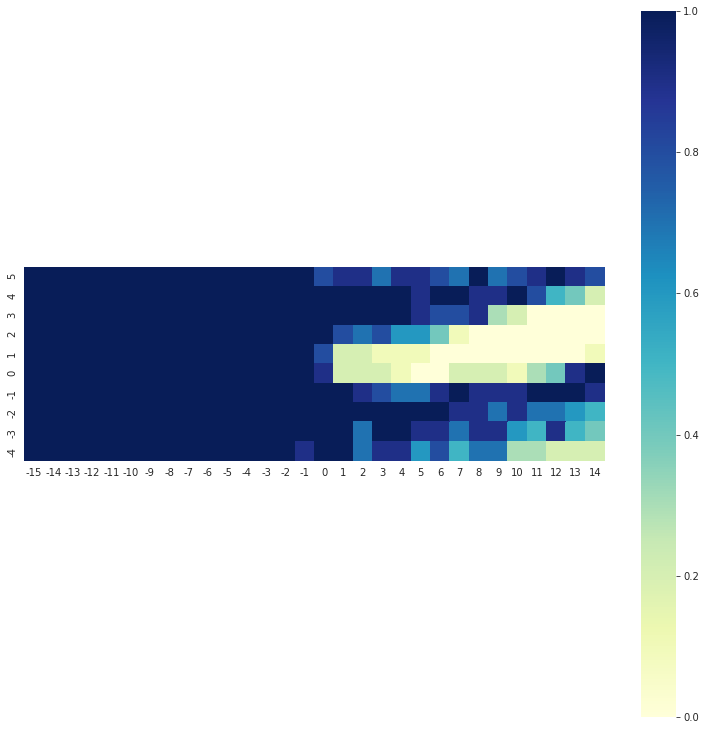

In [11]:
ana_cma.plot_hotmap_prob()

In [74]:
cma_ln = setup_compsite_cma_bukin(line_search(alpha=1e-5, beta=2e-5))
%time ana_ln = do_multiple_exps_on_bukin(cma_ln, SEED)

complete: 10 / 300 
complete: 20 / 300 
complete: 30 / 300 
complete: 40 / 300 
complete: 50 / 300 
complete: 60 / 300 
complete: 70 / 300 
complete: 80 / 300 
complete: 90 / 300 
complete: 100 / 300 
complete: 110 / 300 
complete: 120 / 300 
complete: 130 / 300 
complete: 140 / 300 
complete: 150 / 300 
complete: 160 / 300 
complete: 170 / 300 
complete: 180 / 300 
complete: 190 / 300 
complete: 200 / 300 
complete: 210 / 300 
complete: 220 / 300 
complete: 230 / 300 
complete: 240 / 300 
complete: 250 / 300 
complete: 260 / 300 
complete: 270 / 300 
complete: 280 / 300 
complete: 290 / 300 
complete: 300 / 300 
avg probility of converge:  0.8663333333333333
avg func value:  0.899872748653291
avg evals per exp:  157721.35366666666


CPU times: user 1h 55min 1s, sys: 1min 6s, total: 1h 56min 8s
Wall time: 2h 4min 38s


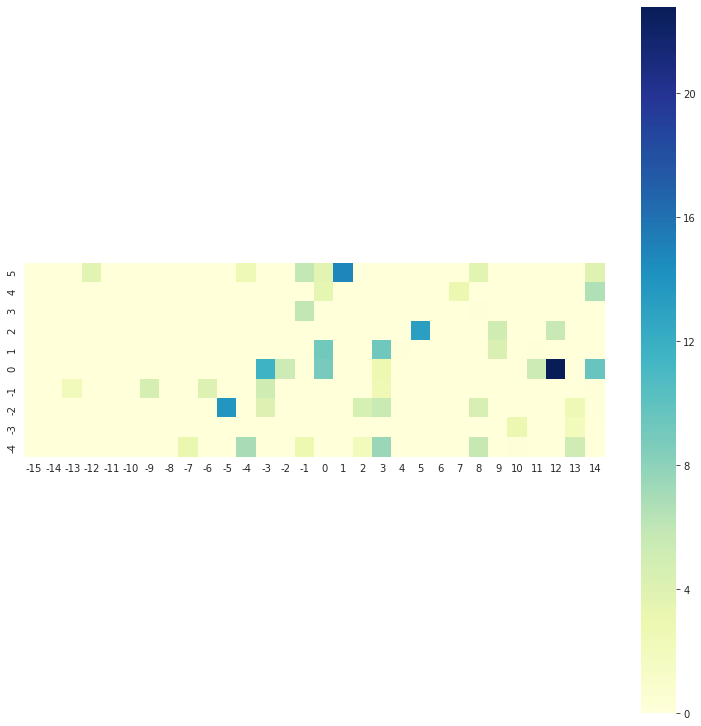

In [75]:
ana_ln.plot_hotmap_cost()

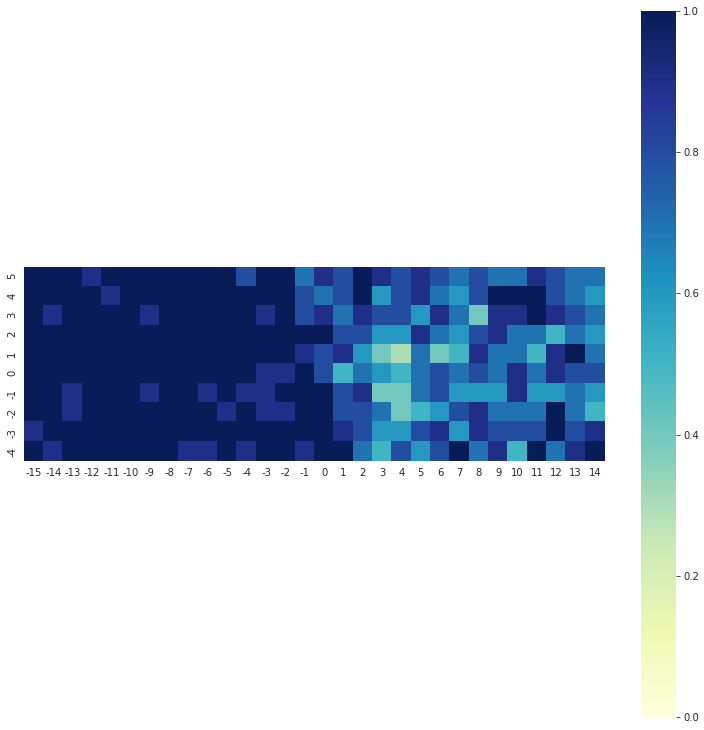

In [76]:
ana_ln.plot_hotmap_prob()

## adam

In [4]:
np.random.seed(SEED)

# init multiple experiments
mexps = multiple_experiment()

# init and setup one experiment
exp = single_experiment()
# One experiment: setup objective function
obj = bukin()
optimizer = adam()
optmizerParas = {
         'x0': None,
         'alpha': 1e-2,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 2000,
         'tol': 1e-3,              
         'verbose': False,
         'record': False }
optimizer.set_parameters(optmizerParas)
exp.set_objective(obj)
exp.set_optimizer(optimizer)

# Multiple experiment: setup one expreiment
mexps.set_single_exp(exp)
# Multiple experiments: setup sample zone of multiple experiments
zoneParas = {'origin': np.array([-15,-5]),
         'edge': np.array([30, 10]),
         'step': 1,
         'size': 10,
         'sym': False}
mexps.set_sample_zone(zoneParas)

data = mexps.do()

cost: 13.722949413503148, prob: 0.0
complete: 10 / 300 
cost: 14.64676433171778, prob: 0.0
complete: 20 / 300 
cost: 15.879292445960768, prob: 0.2
complete: 30 / 300 
cost: 15.685409822598178, prob: 0.0
complete: 40 / 300 
cost: 16.136426772401745, prob: 0.0
complete: 50 / 300 
cost: 16.143902735969824, prob: 0.0
complete: 60 / 300 
cost: 16.214949731760115, prob: 0.0
complete: 70 / 300 
cost: 13.95337255894366, prob: 0.0
complete: 80 / 300 
cost: 14.961455745988243, prob: 0.0
complete: 90 / 300 
cost: 10.02927719248002, prob: 0.0
complete: 100 / 300 
cost: 10.715602949412352, prob: 0.0
complete: 110 / 300 
cost: 12.47368507981316, prob: 0.0
complete: 120 / 300 
cost: 9.493590591813911, prob: 0.0
complete: 130 / 300 
cost: 12.014810651037166, prob: 0.0
complete: 140 / 300 
cost: 13.156984543993985, prob: 0.0
complete: 150 / 300 
cost: 14.324128255506235, prob: 0.0
complete: 160 / 300 
cost: 17.291434256828637, prob: 0.0
complete: 170 / 300 
cost: 16.299287907322586, prob: 0.0
complete:

In [26]:
data['para'] = zoneParas
ana_adam = post_analysis_zone(data)

Text(0.5, 1, 'cost of Bukin function, optimised by Adam')

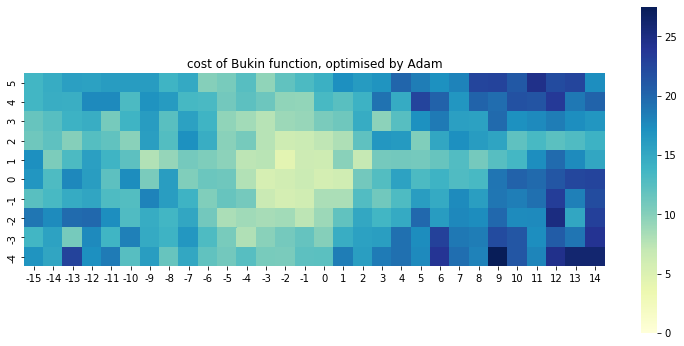

In [28]:
ax = ana_adam.plot_hotmap_cost()
ax.set_title("cost of Bukin function, optimised by Adam")

# eggholder 

## adam

In [3]:
# 1 
obj = eggholder()

# 2
opt = adam()
optParas = {
         'x0': None,
         'alpha': 1e-2,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 2000,
         'tol': 1e-3,              
         'verbose': False,
         'record': False }
opt.set_parameters(optParas)

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([-550,-550]),
             'edge': np.array([1100, 1100]),
             'step': 55,
             'size': 10,
             'sym': False}

data = do_multiple_exps(obj, opt, zoneParas)

cost: 1733.697667932663, prob: 0.0
complete: 20 / 400 
cost: 1360.8598353564116, prob: 0.0
complete: 40 / 400 
cost: 843.0154613373622, prob: 0.0
complete: 60 / 400 
cost: 153.53612567269212, prob: 0.0
complete: 80 / 400 
cost: 117.85828301373101, prob: 0.0
complete: 100 / 400 
cost: 304.5397742853322, prob: 0.0
complete: 120 / 400 
cost: 653.2340803850859, prob: 0.0
complete: 140 / 400 
cost: 847.63662857559, prob: 0.0
complete: 160 / 400 
cost: 1200.7371233453382, prob: 0.0
complete: 180 / 400 
cost: 1609.7988798644133, prob: 0.0
complete: 200 / 400 
cost: 1380.1217928193123, prob: 0.0
complete: 220 / 400 
cost: 1145.4561272331393, prob: 0.0
complete: 240 / 400 
cost: 969.7184757174367, prob: 0.0
complete: 260 / 400 
cost: 1034.1246220652306, prob: 0.0
complete: 280 / 400 
cost: 899.5090684365117, prob: 0.0
complete: 300 / 400 
cost: 402.8877491299786, prob: 0.0
complete: 320 / 400 
cost: 113.77023069489312, prob: 0.0
complete: 340 / 400 
cost: 557.6858374283383, prob: 0.0
complete: 

In [17]:
ana_adam_egg = post_analysis_zone(data)

Text(0.5, 1, 'cost of Eggholder, optimised by Adam')

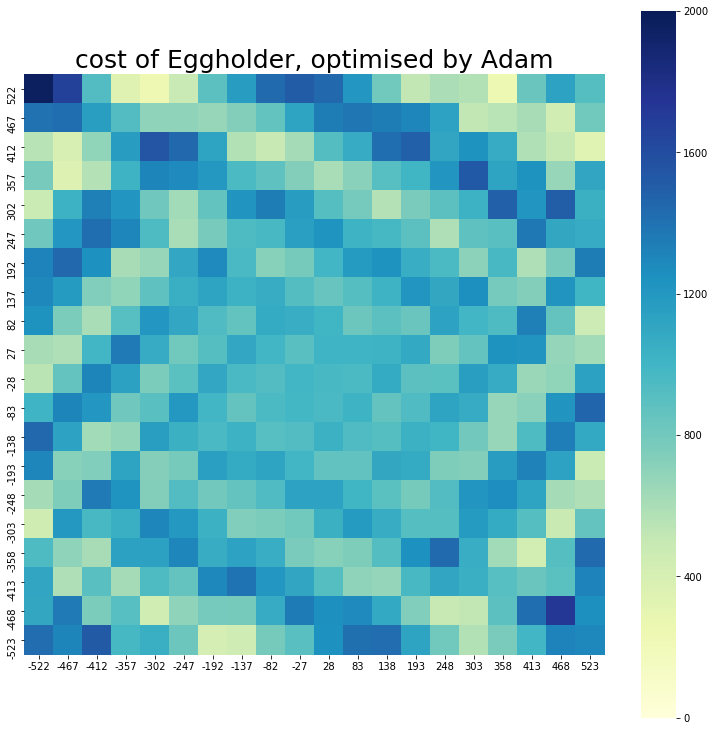

In [69]:
ax = ana_adam_egg.plot_hotmap_cost()
ax.set_title("cost of Eggholder, optimised by Adam", fontsize=25)

## no optimisation

In [13]:
# 1 
obj = eggholder()

# 2
opt = do_nothing()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([-550,-550]),
             'edge': np.array([1100, 1100]),
             'step': 55,
             'size': 10,
             'sym': False}

data = do_multiple_exps(obj, opt, zoneParas)

cost: 1965.5619819738265, prob: 0.0
complete: 20 / 400 
cost: 1666.6980358336623, prob: 0.0
complete: 40 / 400 
cost: 930.7896572955867, prob: 0.0
complete: 60 / 400 
cost: 351.53266115125587, prob: 0.0
complete: 80 / 400 
cost: 238.6697094869779, prob: 0.0
complete: 100 / 400 
cost: 484.6248544649326, prob: 0.0
complete: 120 / 400 
cost: 884.1053712749663, prob: 0.0
complete: 140 / 400 
cost: 1175.3991699518606, prob: 0.0
complete: 160 / 400 
cost: 1443.9465953386461, prob: 0.0
complete: 180 / 400 
cost: 1511.675914294919, prob: 0.0
complete: 200 / 400 
cost: 1450.926719216715, prob: 0.0
complete: 220 / 400 
cost: 1208.8490483662085, prob: 0.0
complete: 240 / 400 
cost: 806.906610464775, prob: 0.0
complete: 260 / 400 
cost: 523.1655109315852, prob: 0.0
complete: 280 / 400 
cost: 599.8631481562587, prob: 0.0
complete: 300 / 400 
cost: 572.6166288029705, prob: 0.0
complete: 320 / 400 
cost: 248.8770815359359, prob: 0.0
complete: 340 / 400 
cost: 842.6144195887686, prob: 0.0
complete: 36

In [19]:
ana_no_egg = post_analysis_zone(data)

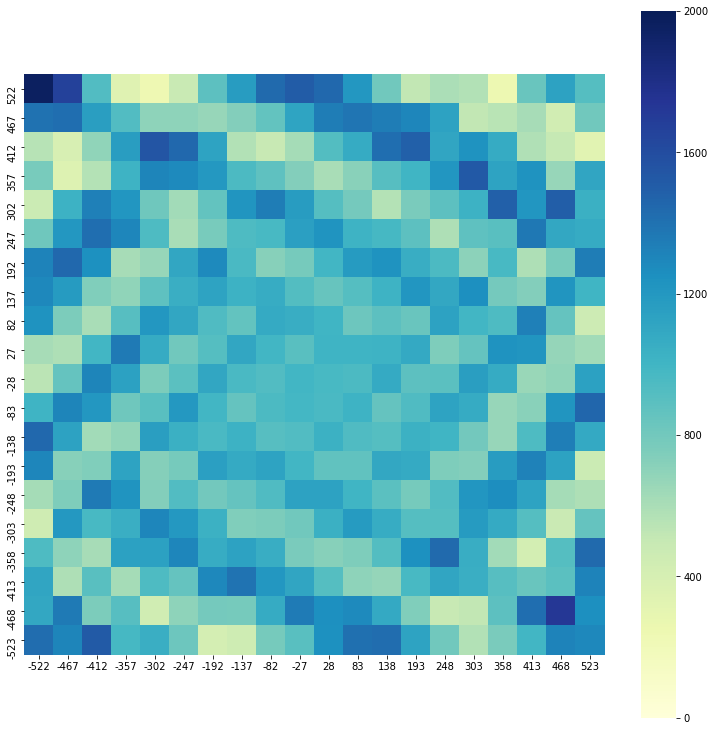

In [20]:
ana_no_egg.plot_hotmap_cost()

## cma 

In [22]:
# 1 optimiser
opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': do_nothing(), 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = eggholder()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([-550,-550]),
             'edge': np.array([1100, 1100]),
             'step': 55,
             'size': 10,
             'sym': False}

data = do_multiple_exps(obj, opt, zoneParas)

cost: 450.9351674756105, prob: 0.0
complete: 20 / 400 
cost: 93.4508545679142, prob: 0.0
complete: 40 / 400 


/Users/huajian/Non-convex/library/optimiser.py:168: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/Non-convex/library/optimiser.py:60: RuntimeWarning:

invalid value encountered in less

/Users/huajian/Non-convex/library/optimiser.py:63: RuntimeWarning:

invalid value encountered in less



diverge, raise LinAlgError!
cost: 80.57931999020921, prob: 0.0
complete: 60 / 400 
cost: 80.5793264661029, prob: 0.0
complete: 80 / 400 
cost: 80.57931030639166, prob: 0.0
complete: 100 / 400 
cost: 80.5793191344596, prob: 0.0
complete: 120 / 400 
cost: 146.63853338876652, prob: 0.0
complete: 140 / 400 
cost: 362.2494774494931, prob: 0.0
complete: 160 / 400 
cost: 329.9892972170207, prob: 0.0
complete: 180 / 400 
cost: 292.2865256960332, prob: 0.0
complete: 200 / 400 
cost: 166.82125877770628, prob: 0.0
complete: 220 / 400 
cost: 230.99936161081695, prob: 0.0
complete: 240 / 400 
cost: 231.0020325095643, prob: 0.0
complete: 260 / 400 
cost: 230.99957576366836, prob: 0.0
complete: 280 / 400 
cost: 188.07620550582484, prob: 0.0
complete: 300 / 400 
diverge, raise LinAlgError!
cost: 94.55442258902283, prob: 0.0
complete: 320 / 400 
cost: 87.92392202295646, prob: 0.0
complete: 340 / 400 
cost: 87.92390591489925, prob: 0.0
complete: 360 / 400 
cost: 38.315273901122154, prob: 0.2
complete: 3

In [23]:
ana_cma_egg = post_analysis_zone(data)

Text(0.5, 1, 'cost of Eggholder, optimised by CMA')

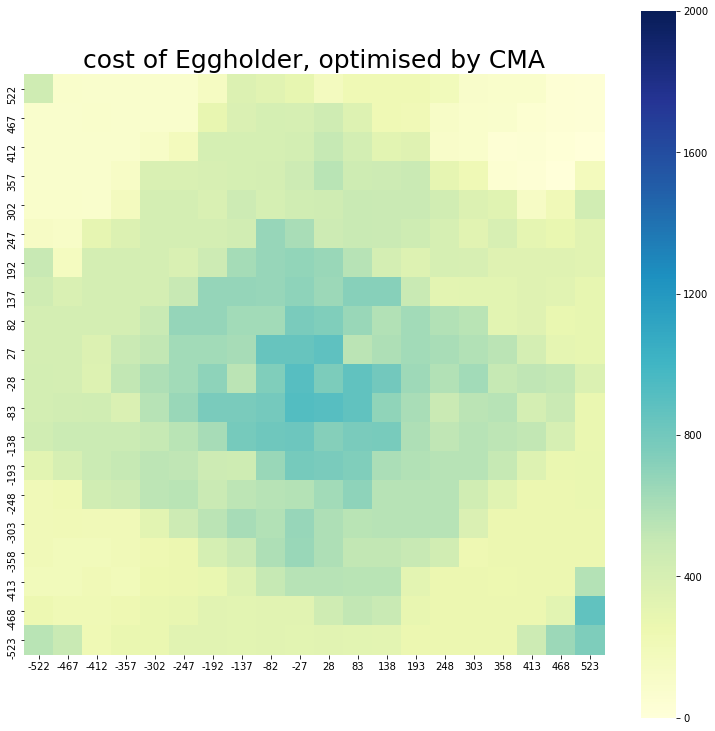

In [70]:
ax = ana_cma_egg.plot_hotmap_cost()
ax.set_title("cost of Eggholder, optimised by CMA", fontsize=25)

## cma-es with line search

In [28]:
# 1 optimiser
inner_opt = line_search()
innerOptParas = {
    'x0': None,
    'alpha': 1,
    'beta': 0.1, 
    'max_iter': 100,
    'tol': 1e-2,              
    'verbose': False,
    'record': False
}
inner_opt.set_parameters(innerOptParas)

opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': inner_opt, 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = eggholder()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([-550,-550]),
             'edge': np.array([1100, 1100]),
             'step': 55,
             'size': 10,
             'sym': False}

data = do_multiple_exps(obj, opt, zoneParas)

/Users/huajian/Non-convex/library/objective_function.py:176: RuntimeWarning:

divide by zero encountered in double_scalars

/Users/huajian/Non-convex/library/objective_function.py:176: RuntimeWarning:

invalid value encountered in double_scalars



cost: 74.69078381104882, prob: 0.0
complete: 20 / 400 
cost: 67.36683225858759, prob: 0.1
complete: 40 / 400 
cost: 82.70905437520736, prob: 0.0
complete: 60 / 400 
cost: 81.82743420995028, prob: 0.0
complete: 80 / 400 
cost: 74.13514663811317, prob: 0.0
complete: 100 / 400 
cost: 92.02828570092106, prob: 0.0
complete: 120 / 400 
cost: 94.25568978578251, prob: 0.0
complete: 140 / 400 
cost: 410.92151192650215, prob: 0.0
complete: 160 / 400 
cost: 412.4320727060228, prob: 0.0
complete: 180 / 400 
cost: 455.06341770686083, prob: 0.0
complete: 200 / 400 
cost: 302.02931640032455, prob: 0.2
complete: 220 / 400 
cost: 268.9335186500843, prob: 0.1
complete: 240 / 400 
cost: 153.358289424014, prob: 0.2
complete: 260 / 400 
cost: 165.3866719406938, prob: 0.3
complete: 280 / 400 
cost: 100.88860941681989, prob: 0.2
complete: 300 / 400 
cost: 80.52643271559924, prob: 0.1
complete: 320 / 400 
cost: 40.55523210725331, prob: 0.3
complete: 340 / 400 
cost: 70.5121183216329, prob: 0.2
complete: 360 /

In [ ]:
ana_cmaln_egg = post_analysis_zone(data)

Text(0.5, 1, 'cost of Eggholder, by CMA with line search')

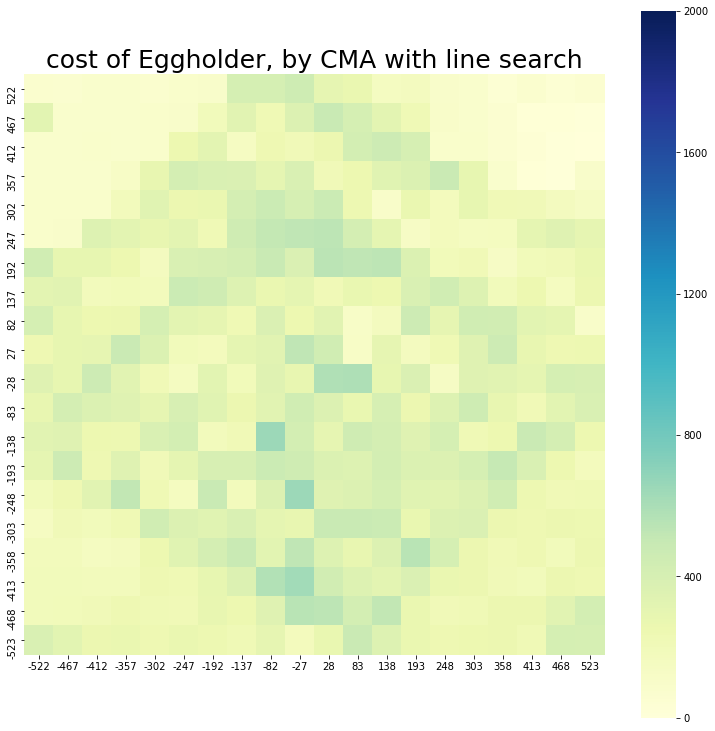

In [71]:
ax = ana_cmaln_egg.plot_hotmap_cost()
ax.set_title("cost of Eggholder, by CMA with line search", fontsize=25)

In [35]:
import time
class multiple_experiment:
    def set_sample_zone(self, paras):
        self.paras = paras
        self.origin = paras['origin']
        self.edge = paras['edge']
        self.step = paras['step']
        self.sym = paras['sym'] if 'sym' in self.paras.keys() else False
        self.size = paras['size']
    def set_single_exp(self, exp):
        self.exp = exp
    def do(self):
        # get derivative parameters
        num_x = int(self.edge[0] / self.step)
        num_y = int(self.edge[1] / self.step)
        abs_edge = np.zeros((2,))
        abs_edge[0] = self.origin[0] + self.edge[0]
        
        # initlise matrix to record results
        data = {}
        data['convergence'] = np.zeros((num_y, num_x))
        data['cost'] = np.zeros_like(data['convergence'])
        data['evals'] = np.zeros_like(data['convergence'])
        data['mask'] = np.ones_like(data['convergence'], dtype=np.uint8)
        data['x'] = np.zeros_like(data['convergence'])
        data['y'] = np.zeros_like(data['convergence'])     
        if self.sym and num_x == num_y:   
            total_num = (num_x + 1) * num_x / 2
        else:
            total_num = num_x * num_y
        
        start = time.time()
        for i, x in enumerate(np.arange(self.origin[0], abs_edge[0], self.step)):
            if self.sym:
                abs_edge[1] = self.origin[1] + x + self.step 
            else:
                abs_edge[1] = self.origin[1] + self.edge[1]
            for j, y in enumerate(np.arange(self.origin[1], abs_edge[1], self.step)):
                points = np.random.rand(self.size, 2) * self.step + np.array([x, y]) 
                data['mask'][num_y-1-j, i] = 0
                data['x'][num_y-1-j, i] = x
                data['y'][num_y-1-j, i] = y
                # calculate the probility of getting global minimum 
                res = np.zeros((self.size, ))
                costs = np.zeros_like(res)
                evals = np.zeros_like(res)
                for k in range(self.size):
                    self.exp.optimizer.x0 = points[k].reshape(2,1)
                    status, costs[k], evals[k] = self.exp.do()
                    if(status == 'global minimum'):
                        res[k] = 1
                data['convergence'][num_y-1-j, i] = np.mean(res)
                data['cost'][num_y-1-j, i] = np.mean(costs)
                data['evals'][num_y-1-j, i] = np.mean(evals)
            if self.sym:
                completed_num = (i + 1) * i / 2 + j + 1
            else:
                completed_num = i * num_y + j + 1
            print("cost: {}, prob: {}".format(data['cost'][num_y-1-j, i], data['convergence'][num_y-1-j, i]) )
            print("complete: {} / {} ".format(int(completed_num), int(total_num)))
        end = time.time()
        if self.sym:
            num = self.edge[0] / self.step
            num = (num + 1) * num / 2
        else:
            num = num_x * num_y
        data['paras'] = self.paras
        print("avg probility of convergence: ", data['convergence'].sum() / num)
        print("avg cost: ", data['cost'].sum() / num)
        print("avg evals per exp: ", data['evals'].sum() / num)
        print("total time: {},  time per eval:{}\n".format(end - start, (end - start)/num/data['evals'].sum()))
        return data

# tuned ackley

In [46]:
class post_analysis_zone:
    def __init__(self, data):
        self.paras = data['paras']
        self.origin = self.paras['origin']
        self.edge = self.paras['edge']
        self.step = self.paras['step']
        
        self.x = data['x']
        self.y = data['y']
        self.prob = data['convergence']
        self.cost = data['cost']
        self.evals = data['evals']
        self.mask = data['mask']
        
        self.xlabel = np.arange(self.origin[0], self.origin[0] + self.edge[0], self.step) + round(self.step/2)
        self.ylabel = np.arange(self.edge[1] + self.origin[1], self.origin[1], -self.step) - round(self.step/2)
        
    def __setup_axis(self, ax):
        sns.axes_style("white")
        ax.set_xticklabels(self.xlabel)
        ax.set_yticklabels(self.ylabel)
        
    def plot_scatter(self):
        fig = plt.figure(figsize=(10,10))
        sc = plt.scatter(self.x.ravel(), self.y.ravel(), c=self.prob.ravel(), marker='o', vmin=0, vmax=1, s=35, cmap='YlGnBu')
        plt.colorbar(sc)
        return ax
        
    def plot_hotmap_prob(self):
        fig = plt.figure(figsize=(13, 13))
        ax = sns.heatmap(self.prob, mask=self.mask, vmin=0, vmax=1, square=True,  cmap="YlGnBu")
        self.__setup_axis(ax)
        return ax

    def plot_hotmap_cost(self, max_cost):
        fig = plt.figure(figsize=(13, 13))
        ax = sns.heatmap(self.cost, mask=self.mask, vmin=0, vmax=max_cost, square=True,  cmap="YlGnBu")
        self.__setup_axis(ax)
        return ax

    def plot_hotmap_evals(self):
        fig = plt.figure(figsize=(13, 13))
        ax = sns.heatmap(self.evals, mask=self.mask, vmin=0, square=True,  cmap="YlGnBu")  
        self.__setup_axis(ax)
        return ax

## adam

In [52]:
# 1 optimiser
opt = adam()
optParas = {
         'x0': None,
         'alpha': 1e-1,
         'beta_1': 0.9, 
         'beta_2': 0.999, 
         'epsilon': 1e-11, 
         'max_iter': 2000,
         'tol': 1e-3,              
         'verbose': False,
         'record': False }
opt.set_parameters(optParas)

# 2 objective function
obj = tuned_ackley()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([0, 0]),
             'edge': np.array([20, 20]),
             'step': 1,
             'size': 10,
             'sym': True}

data = do_multiple_exps(obj, opt, zoneParas)

cost: 0.05046975578117099, prob: 1.0
complete: 1 / 210 
cost: 0.07337142349514458, prob: 1.0
complete: 3 / 210 
cost: 0.07972452676478632, prob: 0.9
complete: 6 / 210 
cost: 0.03033870781288641, prob: 1.0
complete: 10 / 210 
cost: 0.04157528313194767, prob: 1.0
complete: 15 / 210 
cost: 0.03769242682142071, prob: 1.0
complete: 21 / 210 
cost: 0.030206372102839652, prob: 1.0
complete: 28 / 210 
cost: 7.451499436980349, prob: 0.5
complete: 36 / 210 
cost: 14.874908617009126, prob: 0.0
complete: 45 / 210 
cost: 14.645257325100687, prob: 0.0
complete: 55 / 210 
cost: 14.64517426910867, prob: 0.0
complete: 66 / 210 
cost: 12.67690612632906, prob: 0.0
complete: 78 / 210 
cost: 12.680142978423703, prob: 0.0
complete: 91 / 210 
cost: 8.580159502602905, prob: 0.0
complete: 105 / 210 
cost: 8.269187847594358, prob: 0.0
complete: 120 / 210 
cost: 50.0, prob: 0.0
complete: 136 / 210 
cost: 50.0, prob: 0.0
complete: 153 / 210 
cost: 50.0, prob: 0.0
complete: 171 / 210 
cost: 50.0, prob: 0.0
complet

In [53]:
ana_ad_tak = post_analysis_zone(data)

Text(0.5, 1, 'cost of tuned ackley, optimised by adam')

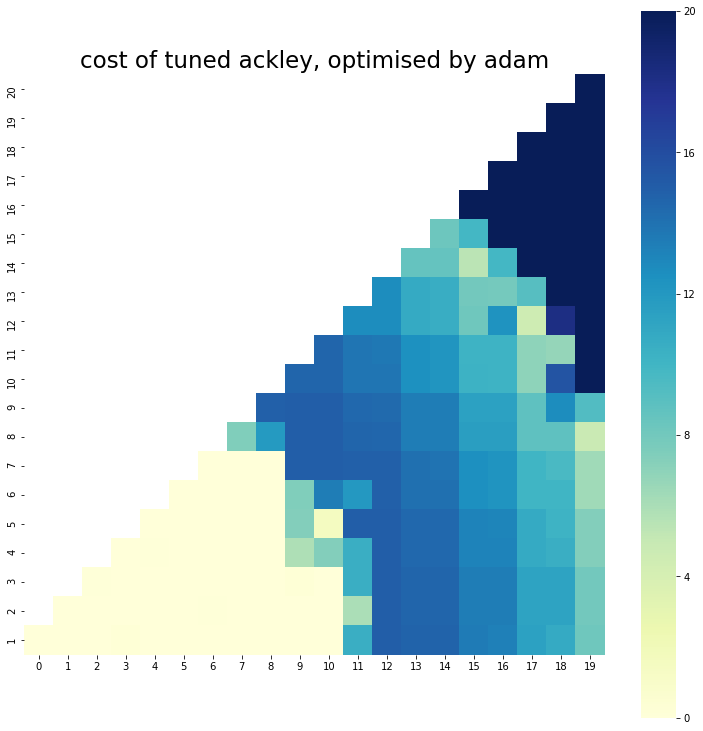

In [66]:
ax = ana_ad_tak.plot_hotmap_cost(20)
ax.set_title("cost of tuned ackley, optimised by adam", fontsize=23)

In [55]:
# 1 optimiser
opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': do_nothing(), 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = tuned_ackley()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([0, 0]),
             'edge': np.array([20, 20]),
             'step': 1,
             'size': 10,
             'sym': True}

data = do_multiple_exps(obj, opt, zoneParas)

cost: 0.0002949743494571777, prob: 1.0
complete: 1 / 210 
cost: 0.0003050879612477075, prob: 1.0
complete: 3 / 210 
cost: 0.0003554989528986141, prob: 1.0
complete: 6 / 210 
cost: 0.0003906634434454048, prob: 1.0
complete: 10 / 210 
cost: 0.00021844765305729653, prob: 1.0
complete: 15 / 210 
cost: 0.0003064333273691489, prob: 1.0
complete: 21 / 210 
cost: 0.00034168304938155816, prob: 1.0
complete: 28 / 210 
cost: 0.7239307139524722, prob: 0.9
complete: 36 / 210 
cost: 0.858158878424295, prob: 0.9
complete: 45 / 210 
cost: 0.4729429467536347, prob: 0.9
complete: 55 / 210 
cost: 4.121557484795035, prob: 0.2
complete: 66 / 210 
cost: 4.113651954052825, prob: 0.3
complete: 78 / 210 
cost: 4.6926052038122466, prob: 0.1
complete: 91 / 210 
cost: 4.702962966546354, prob: 0.1
complete: 105 / 210 
cost: 4.374163461250666, prob: 0.2
complete: 120 / 210 
diverge, raise LinAlgError!
cost: 5.3751906323888345, prob: 0.0
complete: 136 / 210 
cost: 9.048296888570686, prob: 0.2
complete: 153 / 210 
co

In [56]:
ana_cma_tak = post_analysis_zone(data)

Text(0.5, 1, 'cost of tuned ackley, optimised by cma')

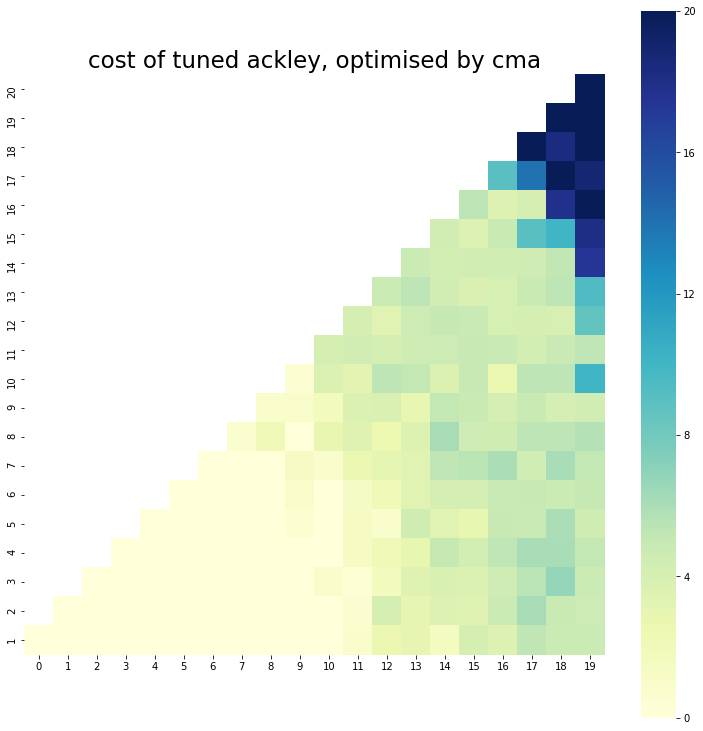

In [64]:
ax = ana_cma_tak.plot_hotmap_cost(20)
ax.set_title("cost of tuned ackley, optimised by cma", fontsize=23)

In [44]:
# 1 optimiser
inner_opt = line_search()
innerOptParas = {
    'x0': None,
    'alpha': 1,
    'beta': 0.1, 
    'max_iter': 100,
    'tol': 1e-2,              
    'verbose': False,
    'record': False
}
inner_opt.set_parameters(innerOptParas)

opt = cma_es()
optParas ={'x0': np.zeros((2,)),
           'std': np.ones((2,)) * 3, 
           'tol': 1e-3, 
           'adjust_func': inner_opt, 
           'record': False, 
           'verbose': False}
opt.set_parameters(optParas)

# 2 objective function
obj = tuned_ackley()

# 3 setup sample zone of multiple experiments
zoneParas = {'origin': np.array([0, 0]),
             'edge': np.array([20, 20]),
             'step': 1,
             'size': 10,
             'sym': True}

data = do_multiple_exps(obj, opt, zoneParas)

cost: 8.497193023728755e-05, prob: 1.0
complete: 1 / 210 
cost: 9.09162180647627e-05, prob: 1.0
complete: 3 / 210 
cost: 0.00010184041187208948, prob: 1.0
complete: 6 / 210 
cost: 0.00010586477659160209, prob: 1.0
complete: 10 / 210 
cost: 0.00013038676066834398, prob: 1.0
complete: 15 / 210 
cost: 4.718785825694738e-05, prob: 1.0
complete: 21 / 210 
cost: 3.660719164493287e-05, prob: 1.0
complete: 28 / 210 
cost: 8.339414890272679e-05, prob: 1.0
complete: 36 / 210 
cost: 6.456661908131878e-05, prob: 1.0
complete: 45 / 210 
cost: 0.4761637468758714, prob: 0.9
complete: 55 / 210 
cost: 0.36672097298630746, prob: 0.9
complete: 66 / 210 
cost: 3.102598063027215, prob: 0.3
complete: 78 / 210 
cost: 1.637405662349958, prob: 0.6
complete: 91 / 210 
cost: 3.0232987150064115, prob: 0.3
complete: 105 / 210 
diverge, raise LinAlgError!
diverge, raise LinAlgError!
cost: 2.6295766229887434, prob: 0.4
complete: 120 / 210 
diverge, raise LinAlgError!
cost: 3.1686605641122583, prob: 0.3
complete: 136

In [ ]:
ana_cmaln_tak = post_analysis_zone(data)

Text(0.5, 1, 'cost of tuned ackley, by cma with line search')

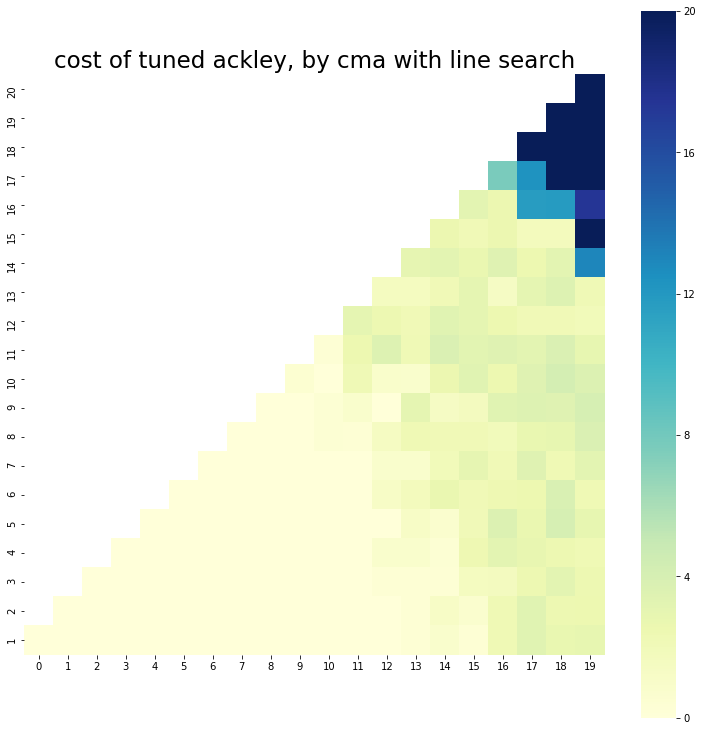

In [63]:
ax = ana_cmaln_tak.plot_hotmap_cost(20)
ax.set_title("cost of tuned ackley, by cma with line search", fontsize=23)